In [1]:
import os
# import psignifit as ps
import glob
# import pickle as pkl
import dill as pkl
import numpy as np
import pylab as pl
import seaborn as sns
import scipy.stats as spstats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Import this before pandas
import pandas as pd
import importlib

import scipy as sp
import itertools
import matplotlib as mpl

In [2]:
import analyze2p.plotting as pplot
import analyze2p.receptive_fields.utils as rfutils

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
#set_plot_params()
visual_areas, area_colors = pplot.set_threecolor_palette() 

In [4]:
# Main src
# aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
# rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data'
traceid = 'traces001'
response_type='dff'
responsive_test='ROC'
responsive_thr = 0.05 if responsive_test=='ROC' else 10.0
trial_epoch = 'plushalf'
overlap_thr=None
overlap_str = 'noRF' if overlap_thr in [None, 'None'] else 'overlap-%.2f' % overlap_thr

fov_type = 'zoom2p0x'
state = 'awake'

src_data_dir = os.path.join(aggregate_dir, 'data-stats', 'tmp_data')

# Load source data

In [5]:
fname = 'neuraldata_%s_%s_%s-thr-%.2f_%s_%s' \
        % (traceid, response_type, responsive_test, responsive_thr, trial_epoch, overlap_str)
src_datafile = os.path.join(src_data_dir, '%s.pkl' % fname)
print(src_datafile)
data_id = os.path.splitext(os.path.split(src_datafile)[-1])[0]
print(data_id)
# Load -----------------------------
with open(src_datafile, 'rb') as f:
    D = pkl.load(f, encoding='latin1')
# print(D.keys())
# DATA = D['DATA']
# sdata = D['sdata']
# SDF = D['SDF']
# # selective_df = D['selective_df']
# # del D

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/neuraldata_traces001_dff_ROC-thr-0.05_plushalf_noRF.pkl
neuraldata_traces001_dff_ROC-thr-0.05_plushalf_noRF


In [6]:
import analyze2p.aggregate_datasets as aggr

In [7]:
# SET PATHS
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'
migr_prefix = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01'
aggregate_dir = aggregate_dir.replace('/n/coxfs01', migr_prefix)
rootdir = rootdir.replace('/n/coxfs01', migr_prefix)
# --
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                create_new=False,
                                return_cells=True, return_missing=True,
                                rootdir=rootdir,
                                aggregate_dir=aggregate_dir)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [8]:
experiment='blobs'
trial_epoch = 'stimulus' #'stimulus'
responsive_test='ROC' #'ROC'
# ---------------------------------------
responsive_thr=0.05 if responsive_test=='ROC' else 10.
response_type='dff'
traceid = 'traces001'

assigned_cells, meta = aggr.select_assigned_cells(cells0, sdata, 
                                        experiments=[experiment])
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                                       response_type=response_type,
                                       trial_epoch=trial_epoch,
                                       responsive_test=responsive_test,
                                       responsive_thr=responsive_thr)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled


In [9]:
## Check stimuli
SDF, incorrect_stims = aggr.check_sdfs(NDATA0['datakey'].unique(), #n_cells_all['datakey'].unique(),
                      experiment='blobs', rename=True, images_only=False,
                      return_incorrect=True, return_all=False)
print(incorrect_stims.keys())

dict_keys(['20190314_JC070_fov1', '20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1', '20190327_JC073_fov1'])


In [10]:
NDATA_ = NDATA0[~NDATA0['datakey'].isin( list(incorrect_stims.keys()))].copy()

# Create an output dir

In [11]:
# output dir
dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', 'AUC')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)
os.listdir(dst_dir)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/AUC


['stripplot_auc_selective-crit-0.70.svg']

# Load AUC dataframe
This is a dataframe with an AUC value for each morph-size stimulus for each cell

In [12]:
#### some params
# import neurometric as pneuro
param = 'morphlevel'
sigmoid='gauss'
allow_negative=True
single_eff=True
if param=='morphstep':
    allow_negative=False
    single_eff=False
sigmoid_dir = '%s_reverse' % sigmoid if not allow_negative else sigmoid
print(sigmoid_dir)
class_a=0
class_b=106
criterion = 0.7
# -------------------------------------------------
selective_only=False
single_eff=True
allow_negative=True
if param=='morphstep':
    single_eff=False
    allow_negative=False

gauss


In [13]:
create_new=False
#### Load AUC 
if selective_only:
    sel_df = selective_df.copy()
else:
    sel_df=None
    
# ----------------------------------
fname = '%s_AUC_single' % param if single_eff else '%s_AUC' % param
tmp_res = os.path.join(aggregate_dir, 'data-stats/tmp_data/%s.pkl' % fname)
orig_fname = tmp_res
make_single=False

# Use numbered morph levels, otherwise use actual morph levels
if param=='morphstep': 
    single_eff=False 
# If using actual morph level, there is only 1 effective morph (2 if using numbered levels)
if single_eff:
    if not os.path.exists(tmp_res):
        print("No single Eff file exists for AUC regular. Creating now.")
        make_single=True
        tmp_res = os.path.join(aggregate_dir, 'data-stats/tmp_data/%s_AUC.pkl' % param)
print(orig_fname)
print("SINGLE: %s" % single_eff)
if not create_new:
    try:
        with open(tmp_res, 'rb') as f:
            AUC = pkl.load(f, encoding='latin1')
            print(AUC.head())
    except Exception as e:
        create_new = True
print(create_new)
if param=='morphlevel':
    if 'object' not in AUC.columns:
        print("Adding object to columns")
        AUC['object'] = 'M'
        AUC.loc[AUC['morphlevel']<53, 'object'] = 'A'
        AUC.loc[AUC['morphlevel']>53, 'object'] = 'B'

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/morphlevel_AUC_single.pkl
SINGLE: True
   cell  level_1  index       AUC  morphlevel  size  Eff  n_trials  \
0   113        0      0  0.551111           0  10.0  106        30   
1   113        1      1  0.500000          14  10.0  106        30   
2   113        2      2  0.545556          27  10.0  106        30   
3   113        3      3  0.487778          40  10.0  106        30   
4   113        4      4  0.601111          53  10.0  106        30   

  visual_area              datakey object  
0          Li  20190315_JC070_fov1      A  
1          Li  20190315_JC070_fov1      A  
2          Li  20190315_JC070_fov1      A  
3          Li  20190315_JC070_fov1      A  
4          Li  20190315_JC070_fov1      M  
False


# Some functions for selectivity

In [14]:
def sel_or_no(sd_, class_a=0, class_b=106, p_thr=0.05):
    '''
    Uses Mann Whitney test to determine if cell 
    responding significantly differently to object A vs. object B anchors
    '''
    a_vals = sd_[(sd_['morphlevel']==class_a)].sort_values(by='trial')['response'].values
    b_vals = sd_[(sd_['morphlevel']==class_b)].sort_values(by='trial')['response'].values
    t, p = spstats.mannwhitneyu(a_vals, b_vals)
    return p<p_thr

def is_selective(rdf, p_thr=0.05, class_a=0, class_b=106):
    '''
    For each size, return True if cell responds significantly to A or B, False otherwise.
    '''
    return any(rdf.groupby(['size']).apply(sel_or_no, class_a=class_a, class_b=class_b, p_thr=p_thr))


# Get both AUC and selectivity pass test

In [15]:
#### Only select cells with min. response > crit
criterion = 0.7
# sdf = SDF['20190522_JC084_fov1'].copy() # Just pick a dset w standard cfgs
sdf = SDF[SDF['datakey']=='20190522_JC084_fov1'].copy()
morphlevels = [i for i in sorted(sdf['morphlevel'].unique()) if i!=-1]
anchors_ = [i for ii in [morphlevels[0:2], morphlevels[-2:]] for i in ii]
max_level = 4 if param=='morphstep' else 1
if param=='morphlevel':
    pAUC_anchors = AUC[(AUC['morphlevel'].isin(anchors_)) 
                       & (AUC['AUC']>=criterion)].copy()
else:
    pAUC_anchors = AUC[(AUC['AUC']>=criterion)].copy()
print(pAUC_anchors.shape)
# pAUC = pd.concat([g for (va, dk, c), g in AUC.groupby(['visual_area', 'datakey', 'cell']) \
#                   if g['AUC'].max()>=criterion])
passkeys = list([tuple(k) for k in \
                 pAUC_anchors[['visual_area', 'datakey', 'cell']]\
                 .drop_duplicates().values])
pAUC = pd.concat([g for (v,k,r), g in AUC.groupby(['visual_area', 'datakey', 'cell'])\
                 if (v, k, r) in passkeys])
print("Total N cells fit:")
print(AUC[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())
print("N cells pass (crit=%.2f):" % criterion)
print(pAUC_anchors[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

(2344, 11)
Total N cells fit:
             datakey  cell
visual_area               
Li               644   644
Lm              1101  1101
V1              1251  1251
N cells pass (crit=0.70):
             datakey  cell
visual_area               
Li               219   219
Lm               401   401
V1               610   610


#### selective or no

In [16]:
diff_configs = ['20190314_JC070_fov1']
class_a=0; class_b=106;
verbose=True
selective_only = True
if selective_only:
    d_=[]
    for (va, dk), ndf in NDATA0.groupby(['visual_area', 'datakey']):
        if dk in diff_configs:
            continue
        if dk in SDF.keys():
            sdf = SDF[dk].copy()
        else:
            sdf = D['SDF'][dk].copy()
            
        ndf['size'] = [sdf['size'][c] for c in ndf['config']]
        ndf['morphlevel'] = [sdf['morphlevel'][c] for c in ndf['config']]
        # Get cells selective to A or B (Mann-Whitney U test)
        s0 = ndf[ndf.morphlevel.isin([class_a, class_b])].groupby(['cell']).apply(is_selective)
        selective_cells = s0[s0==True].index.tolist()
        if verbose:
            print("... (%s) %i of %i cells selective" % (dk, len(selective_cells), len(ndf['cell'].unique())))
        # For selctive cells, calculate selectivity index (-1=prefers B, +1=prefers A)
        selective_ = ndf[ndf['cell'].isin(selective_cells)].copy()
        mean_anchors = selective_[selective_.morphlevel.isin([class_a, class_b])]\
                    .groupby(['visual_area', 'datakey', 'cell', 'size', 'morphlevel'])\
                    .mean().reset_index()
        a_vals = mean_anchors[mean_anchors.morphlevel==class_a]['response'].values
        b_vals = mean_anchors[mean_anchors.morphlevel==class_b]['response'].values
        sel_ixs = (a_vals - b_vals) / (a_vals+b_vals)
        df_ = mean_anchors[['visual_area', 'datakey', 'cell', 'size']].drop_duplicates()
        assert df_.shape[0]==len(sel_ixs), "Bad column drop..."
        df_['sel_ix'] = sel_ixs
        d_.append(df_)
    selective_df = pd.concat(d_).reset_index(drop=True)
    selective_df.head()

... (20190315_JC070_fov1) 13 of 22 cells selective
... (20190316_JC070_fov1) 2 of 7 cells selective
... (20190319_JC067_fov1) 0 of 2 cells selective
... (20190320_JC067_fov1) 0 of 1 cells selective
... (20190321_JC070_fov1) 0 of 1 cells selective
... (20190322_JC073_fov1) 14 of 38 cells selective
... (20190327_JC073_fov1) 8 of 26 cells selective
... (20190422_JC076_fov1) 19 of 29 cells selective
... (20190602_JC091_fov1) 64 of 87 cells selective
... (20190606_JC091_fov1) 25 of 48 cells selective
... (20190607_JC091_fov1) 19 of 52 cells selective
... (20190609_JC099_fov1) 25 of 60 cells selective
... (20190612_JC099_fov1) 13 of 41 cells selective
... (20190614_JC091_fov1) 23 of 78 cells selective
... (20190617_JC099_fov1) 3 of 7 cells selective
... (20191018_JC113_fov1) 18 of 47 cells selective
... (20191111_JC120_fov1) 8 of 30 cells selective
... (20190322_JC073_fov1) 11 of 25 cells selective
... (20190327_JC073_fov1) 3 of 6 cells selective
... (20190422_JC076_fov1) 7 of 22 cells selec

In [17]:
#### Out of cells that pass criterion (AUC > 0.7), only select 
# the SELECTIVE cells, based on Mann-Whitney test
selective_only=True
selective_str = 'selective' if selective_only else "allcells"
if selective_only:
    print("... getting SELECTIVE only")
    s_=[] 
    # pAUC_anchors only?
    # IF using OLD NEURALDATA:
#     for (va, dk), g in pAUC_anchors.groupby(['visual_area', 'datakey']):
#         curr_cells_auc = g['cell'].unique()
#         curr_cells_sel = selective_df[(selective_df.visual_area==va) 
#                                     & (selective_df.datakey==dk)]['cell'].unique()
#         sel_and_auc = np.intersect1d(curr_cells_auc, curr_cells_sel)
#         s_.append(g[g['cell'].isin(sel_and_auc)])
#     pSEL = pd.concat(s_, axis=0).reset_index(drop=True)
    # If using NDATA:
    for (va, dk), g in NDATA_.groupby(['visual_area', 'datakey']):
        curr_cells = g['cell'].unique()
        curr_cells_sel = selective_df[(selective_df.visual_area==va) 
                                    & (selective_df.datakey==dk)]['cell'].unique()
        curr_cells_auc = pAUC_anchors[(pAUC_anchors['datakey']==dk) 
                               & (pAUC_anchors['cell'].isin(curr_cells))]['cell'].unique()
        sel_and_auc = np.intersect1d(curr_cells_auc, curr_cells_sel)
        auc_add = pAUC_anchors[(pAUC_anchors['datakey']==dk) 
                               & (pAUC_anchors['cell'].isin(sel_and_auc))]
        s_.append(auc_add)
    pSEL = pd.concat(s_, axis=0).reset_index(drop=True)
else:
    pSEL = pAUC.copy()

pSEL = pSEL.drop(['level_1', 'index'], axis=1).drop_duplicates()
print(pSEL[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

... getting SELECTIVE only
             datakey  cell
visual_area               
Li               104   104
Lm               217   217
V1               454   454


## Calculate mean

In [18]:
meanAUC = pSEL.groupby(['visual_area', 'datakey', 'cell', 'Eff']).mean().reset_index()

# Plot

In [19]:
%matplotlib notebook

<IPython.core.display.Javascript object>


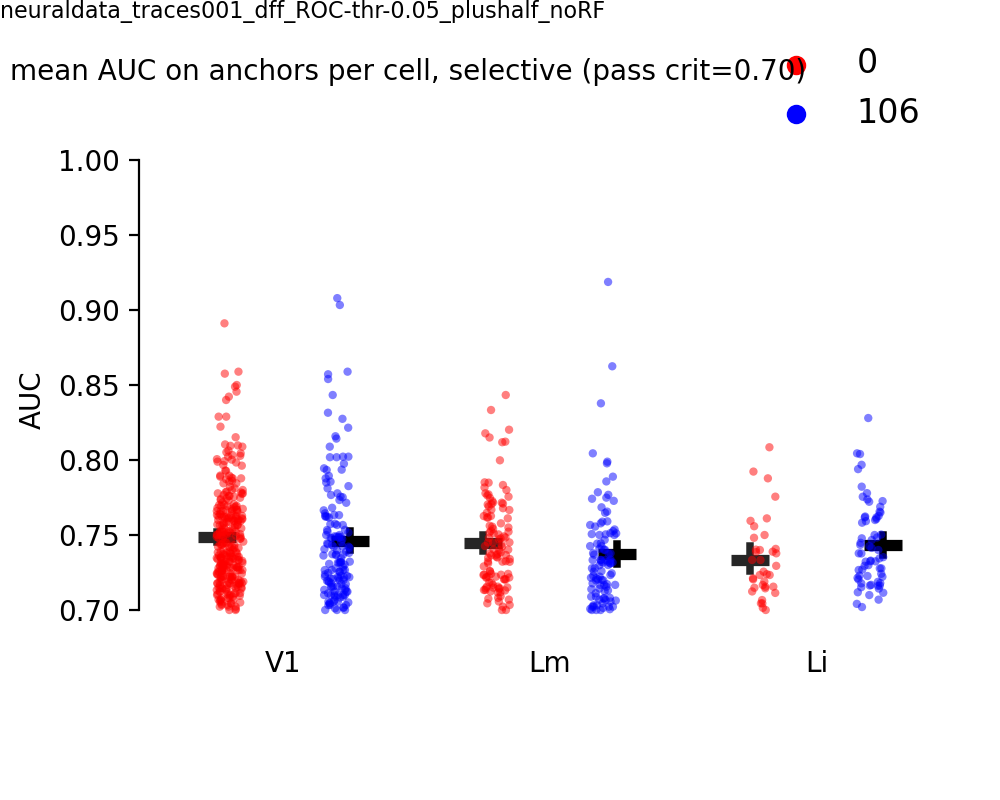

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.1477136475930195, 0.14772002848141771, 0.1476949000552352)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/AUC stripplot_auc_selective-crit-0.70


In [20]:
object_colors = {'A': 'r', 'B': 'b', 0:'r', 106: 'b'}
visual_areas=['V1', 'Lm', 'Li']
fig, ax = pl.subplots(figsize=(5,4), dpi=100)
sns.stripplot(x='visual_area', y='AUC', hue='Eff', data=meanAUC, ax=ax, #zorder=-1,
             dodge=0.5, palette=object_colors, alpha=0.5,size=3, order=visual_areas)
sns.pointplot(x='visual_area', y='AUC', hue='Eff', data=meanAUC, ax=ax,
             join=False, dodge=0.5, color='k', markers='_', order=visual_areas,
            scale=2) #zorder=-1,  scale=2)
ax.set_ylim([0.68, 1])
ax.tick_params(which='both', axis='x', size=0)
sns.despine(trim=True, offset=4, bottom=True)
ax.set_xlabel('')
fig.text(0.01, 0.9, 'mean AUC on anchors per cell, %s (pass crit=%.2f)' % (selective_str, criterion))
pplot.crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1,1), loc='lower right')
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, top=0.8)
pplot.label_figure(fig, data_id)
figname = 'stripplot_auc_%s-crit-%.2f' % (selective_str, criterion)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [21]:
meanAUC.groupby(['visual_area'])['cell'].nunique()

visual_area
Li     90
Lm    163
V1    271
Name: cell, dtype: int64

# Stats

In [22]:
import pingouin as pg

In [23]:
meanAUC['subject'] = np.arange(0, len(meanAUC))
meanAUC

,visual_area,datakey,cell,Eff,AUC,morphlevel,size,n_trials,subject
0,Li,20190422_JC076_fov1,119,0,0.750000,0.0,10.0,30.0,0
1,Li,20190422_JC076_fov1,194,106,0.720370,40.0,20.0,30.0,1
2,Li,20190422_JC076_fov1,261,106,0.804444,106.0,30.0,30.0,2
3,Li,20190422_JC076_fov1,292,106,0.737778,106.0,50.0,30.0,3
4,Li,20190422_JC076_fov1,296,106,0.765556,14.0,10.0,30.0,4
...,...,...,...,...,...,...,...,...,...
770,V1,20191006_JC110_fov1,310,0,0.749527,7.0,50.0,33.0,770
771,V1,20191006_JC110_fov1,338,106,0.748106,106.0,30.0,33.0,771
772,V1,20191006_JC110_fov1,353,106,0.763258,97.6,40.0,33.0,772
773,V1,20191006_JC110_fov1,364,106,0.719697,106.0,10.0,33.0,773


In [24]:
meanAUC.groupby(['visual_area', 'Eff']).count()

datakey  cell  AUC  morphlevel  size  n_trials  subject
visual_area Eff                                                         
Li          0         37    37   37          37    37        37       37
            106       67    67   67          67    67        67       67
Lm          0        115   115  115         115   115       115      115
            106      102   102  102         102   102       102      102
V1          0        305   305  305         305   305       305      305
            106      149   149  149         149   149       149      149

In [25]:
# Create a sample dataframe
# data = pd.DataFrame({
#     'dv': [10, 12, 15, 11, 13, 16, 18, 17, 20, 19],
#     'factor1': ['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C', 'C'],
#     'factor2': ['X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y', 'Z', 'X']
# })
# Perform the two-way ANOVA
aov = pg.anova(data=meanAUC, dv='AUC', 
               between=['visual_area', 'Eff'], detailed=True)
# aov = pg.mixed_anova(dv='AUC', within='Eff', between='visual_area', 
#                      subject='subject', data=meanAUC)
print(aov)

              Source        SS     DF        MS         F     p-unc       np2
0        visual_area  0.007910    2.0  0.003955  3.455147  0.032074  0.008906
1                Eff  0.001102    1.0  0.001102  0.962371  0.326899  0.001250
2  visual_area * Eff  0.004942    2.0  0.002471  2.158843  0.116158  0.005583
3           Residual  0.880232  769.0  0.001145       NaN       NaN       NaN


In [26]:
# Run pairwise comparisons for the visual area factor
posthoc = pg.pairwise_tests(
    dv='AUC', between='visual_area', data=meanAUC, padjust='bonferroni'
)
print(posthoc)

      Contrast   A   B  Paired  Parametric         T         dof alternative  \
0  visual_area  Li  Lm   False        True -0.403317  241.127847   two-sided   
1  visual_area  Li  V1   False        True -2.554588  193.542209   two-sided   
2  visual_area  Lm  V1   False        True -2.382160  459.129708   two-sided   

      p-unc    p-corr    p-adjust   BF10    hedges  
0  0.687072  1.000000  bonferroni  0.142 -0.044926  
1  0.011400  0.034201  bonferroni  2.713 -0.234331  
2  0.017618  0.052853  bonferroni  1.451 -0.190665  


In [27]:
meanAUC['subject'] = meanAUC['subject'].astype('category')
meanAUC['Eff'] = meanAUC['Eff'].astype('category')
meanAUC['visual_area'] = meanAUC['visual_area'].astype('category')
meanAUC['AUC'] = pd.to_numeric(meanAUC['AUC'], errors='coerce')

In [28]:
print(meanAUC.groupby(['subject', 'Eff']).size())

subject  Eff
0        0      1
         106    0
1        0      0
         106    1
2        0      0
               ..
772      106    1
773      0      0
         106    1
774      0      0
         106    1
Length: 1550, dtype: int64


# Check traces

In [29]:
import analyze2p.extraction.traces as traceutils

In [30]:
meanAUC[meanAUC['AUC']>0.9]

,visual_area,datakey,cell,Eff,AUC,morphlevel,size,n_trials,subject
132,Lm,20190504_JC078_fov1,194,106,0.918704,99.0,40.0,30.0,132
344,V1,20190507_JC083_fov1,8,106,0.907917,99.0,35.0,30.0,344
370,V1,20190507_JC083_fov1,126,106,0.903333,99.0,40.0,30.0,370


In [31]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [32]:
dk = '20190507_JC083_fov1'
df_ = NDATA0[NDATA0['datakey']==dk].copy()
df_['response'].min()

-0.8256067684339292

In [33]:
check_rois= []
for cell, d in df_.groupby('cell'):
    if d.groupby('config').mean()['response'].min() < 0:
        break
        check_rois.append(cell)

In [34]:
cell

1

In [35]:
d.groupby('config').mean()['response'] #.min() 

config
config001   -0.024067
config002   -0.013435
config003   -0.010424
config004   -0.017304
config005   -0.021417
config006    0.205143
config007    0.145188
config008    0.024305
config009   -0.011621
config010   -0.009381
config011    0.290069
config012    0.169144
config013    0.032404
config014   -0.004325
config015   -0.005911
config016    0.223154
config017    0.163677
config018    0.049544
config019   -0.009567
config020   -0.007799
config021    0.297743
config022    0.232639
config023    0.033608
config024   -0.007226
config025   -0.012134
config026    0.229691
config027    0.322267
config028    0.062799
config029   -0.001499
config030   -0.002485
config031    0.358606
config032    0.287184
config033    0.055888
config034    0.014613
config035    0.005343
config036    0.592344
config037    0.364369
config038    0.077725
config039    0.003713
config040   -0.002190
config041    0.450133
config042    0.265296
config043    0.082168
config044    0.021960
config045   -0.003205
con

In [36]:
rid = 1
df_[df_['cell']==rid].groupby('config').mean()

,trial,response
config,,
config001,746.300000,-0.024067
config002,749.533333,-0.013435
config003,753.366667,-0.010424
config004,747.800000,-0.017304
config005,750.300000,-0.021417
config006,748.633333,0.205143
config007,753.433333,0.145188
config008,750.533333,0.024305
config009,754.000000,-0.011621


In [37]:
dk = '20190507_JC083_fov1'
# ------------------
data_fpath = traceutils.get_data_fpath(dk, experiment_name='blobs',
                                       rootdir=rootdir)
print(data_fpath)
raw_traces, labels, sdf, run_info = traceutils.load_dataset(data_fpath, 
                                                    trace_type='corrected',
                                                    rootdir=rootdir)
processed, trialmetrics = aggr.process_traces(raw_traces, labels, 
                        trace_type='dff', 
                        response_type='dff', trial_epoch='stimulus')

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_8afe5f_traces001_7ab5af_traces001_488b31_traces001_c8dfc7_traces001_df5b92_traces001_431894/data_arrays/corrected.npz
--- processed traces: dff


In [73]:
# tmat = []
# for k, g in labels.groupby('trial'):
#     t_ = processed.loc[g.index].copy()
#     if t_.min().min() < 0:
#         t_ -= t_.min()
#     tmat.append(t_)
# processed2 = pd.concat(tmat, axis=0)

In [38]:
sdf = SDF[SDF['datakey']==dk].copy()
sdf['morph-size'] = ['{}_{}'.format(m, s) for m, s \
                         in sdf[['morphlevel', 'size']].values]
sdf['config'] = sdf.index.tolist()
cfgs_ = sdf.index.tolist() #sdf[sdf['size']==30].index.tolist()

In [39]:
rid = 1
tdf = traceutils.get_mean_and_std_traces(rid, processed, labels, 
                    cfgs_, sdf, #sdf[sdf.morphlevel.isin(morphlevels)], 
                    param='config', 
                    return_stacked=True, smooth=True, win_size=9)

tdf['morph-size'] = ['{}_{}'.format(sdf.loc[c]['morphlevel'], sdf.loc[c]['size']) \
                     for c in tdf['config'].values]
tdf['morphlevel'] = [m.split('_')[0] for m in tdf['morph-size']]
tdf['size'] = [m.split('_')[1] for m in tdf['morph-size']]
tdf

In [42]:
%matplotlib notebook

In [43]:
sns.color_palette('viridis', n_colors=5)

[(0.267968, 0.223549, 0.512008),
 (0.190631, 0.407061, 0.556089),
 (0.127568, 0.566949, 0.550556),
 (0.20803, 0.718701, 0.472873),
 (0.565498, 0.84243, 0.262877)]

[10.0, 20.0, 30.0, 40.0, 50.0]


<IPython.core.display.Javascript object>


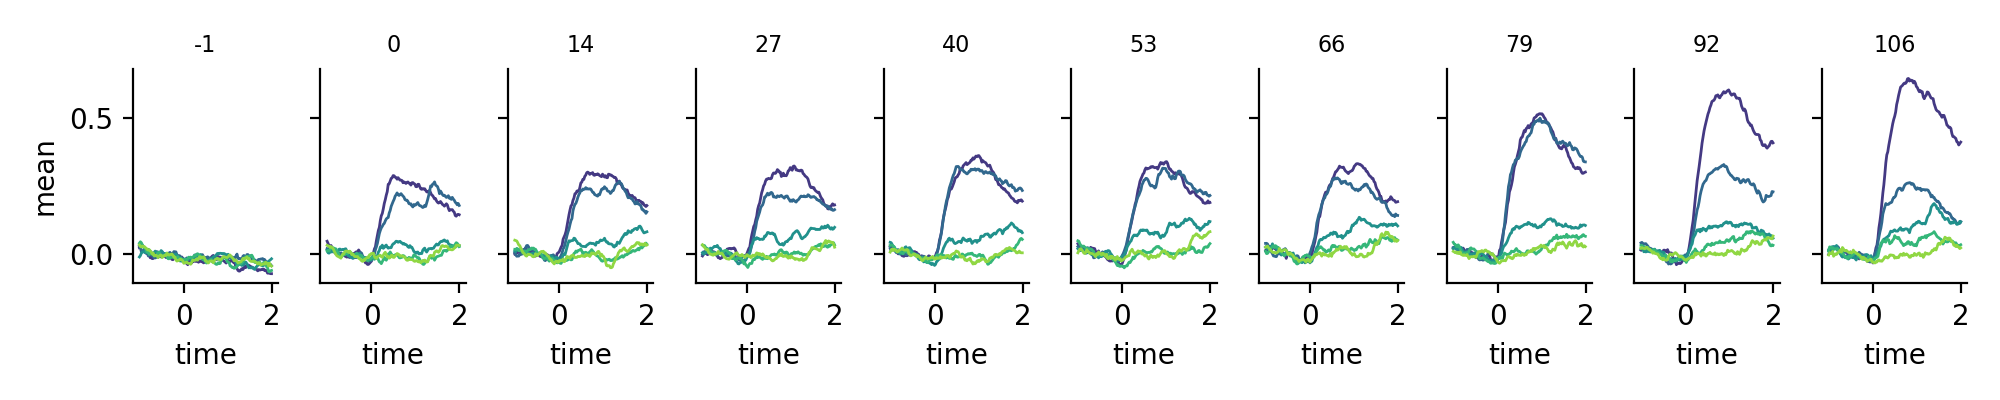

In [44]:
sizes = sorted(sdf['size'].unique())
print(sizes)
hue_var = 'morphlevel'
fg = sns.FacetGrid(data=tdf, col='morphlevel', #col_order=morphlevels, 
                   #row='size', row_order=sizes, 
                   height=2, aspect=0.5, hue='size', #hue_order=sizes,
                   palette='viridis')
fg.map(pl.plot, 'time', 'mean', lw=1)
fg.set_titles('{col_name}', size=8)

In [45]:
# Compare mean dF/F during mean time course per condition
# to calculated mean stat from NDATA:

In [46]:
meanr = dict()
for cf, tc in tdf.groupby('config'):
    start_ix = tc[tc['time']==0].iloc[0].name
    stop_ix = tc[tc['time']>=1].iloc[0].name
    m = np.mean(tc.loc[start_ix:stop_ix]['mean'])
    meanr[cf] = m
meanr_df = pd.Series(meanr)

In [47]:
rid = 1
ndata_mean = df_[df_['cell']==rid].groupby('config').mean().reset_index()
ndata_mean['morph-size'] = ['{}_{}'.format(sdf.loc[c]['morphlevel'], sdf.loc[c]['size']) \
                     for c in ndata_mean['config'].values]
ndata_mean['morphlevel'] = [float(m.split('_')[0]) for m in ndata_mean['morph-size']]
ndata_mean['size'] = [float(m.split('_')[1]) for m in ndata_mean['morph-size']]
ndata_mean['cell'] = rid

In [48]:
for i, v in ndata_mean.iterrows(): #ndata_mean['response']
    v1 = meanr_df.loc[v['config']]
    v2 = v['response']
    if round(v1, 2) != round(v2, 2):
        print('{}: mismatch, {:.2f} vs. {:.2f}'.format(v['morph-size'], v1, v2))

14_10.0: mismatch, 0.22 vs. 0.29
14_40.0: mismatch, -0.01 vs. -0.00
27_10.0: mismatch, 0.23 vs. 0.22
40_10.0: mismatch, 0.24 vs. 0.30
53_20.0: mismatch, 0.21 vs. 0.32
66_10.0: mismatch, 0.22 vs. 0.36
66_20.0: mismatch, 0.21 vs. 0.29
66_40.0: mismatch, 0.02 vs. 0.01
66_50.0: mismatch, 0.00 vs. 0.01
79_10.0: mismatch, 0.33 vs. 0.59
79_20.0: mismatch, 0.32 vs. 0.36
92_10.0: mismatch, 0.40 vs. 0.45
92_20.0: mismatch, 0.22 vs. 0.27
106_10.0: mismatch, 0.43 vs. 0.63
106_40.0: mismatch, 0.04 vs. 0.03


In [49]:
import analyze2p.objects.selectivity as sel

In [50]:
# sel.size_tolerance(ndata_mean['response'])
sel.assign_size_tolerance(ndata_mean)

,size_tol,best_morphlevel
1,0.110169,106.0


In [51]:
sel.assign_morph_ix(ndata_mean)

,morph_sel,best_size
1,0.535071,10.0


In [52]:
ndata_mean[ndata_mean['morphlevel']==106]

,config,trial,response,morph-size,morphlevel,size,cell
45,config046,751.433333,0.626814,106_10.0,106.0,10.0,1
46,config047,747.000000,0.184386,106_20.0,106.0,20.0,1
47,config048,748.600000,0.068265,106_30.0,106.0,30.0,1
48,config049,750.100000,0.034248,106_40.0,106.0,40.0,1
49,config050,751.266667,-0.010679,106_50.0,106.0,50.0,1


In [53]:
# Double-check size tolerance
vals = ndata_mean[ndata_mean['morphlevel']==106]['response'].copy()
vals_norm = vals/max(vals)
np.mean(vals_norm[vals_norm<1])

0.1101686537445339

In [54]:
# Double-check morph sel
# ndata_mean[ndata_mean['size']==10]
vals2 = ndata_mean[ndata_mean['size']==10]['response'].copy()
( len(vals2) - ( sum(vals2)/max(vals2)) ) / (len(vals2)-1)

0.5350709298477122

#### adding offset on trace

[10.0, 20.0, 30.0, 40.0, 50.0]


<IPython.core.display.Javascript object>


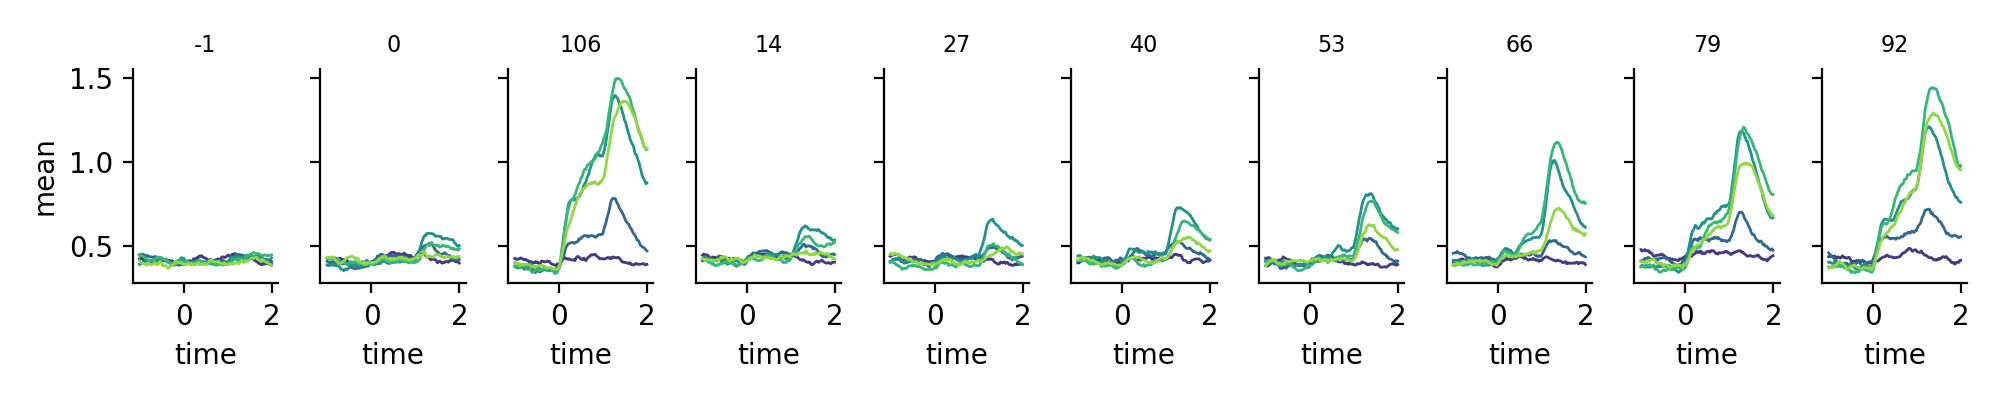

In [78]:
sizes = sorted(sdf['size'].unique())
print(sizes)
hue_var = 'morphlevel'
fg = sns.FacetGrid(data=tdf, col='morphlevel', #col_order=morphlevels, 
                   #row='size', row_order=sizes, 
                   height=2, aspect=0.5, hue='size', palette='viridis')
fg.map(pl.plot, 'time', 'mean', lw=1)
fg.set_titles('{col_name}', size=8)

[10.0, 20.0, 30.0, 40.0, 50.0]


<IPython.core.display.Javascript object>


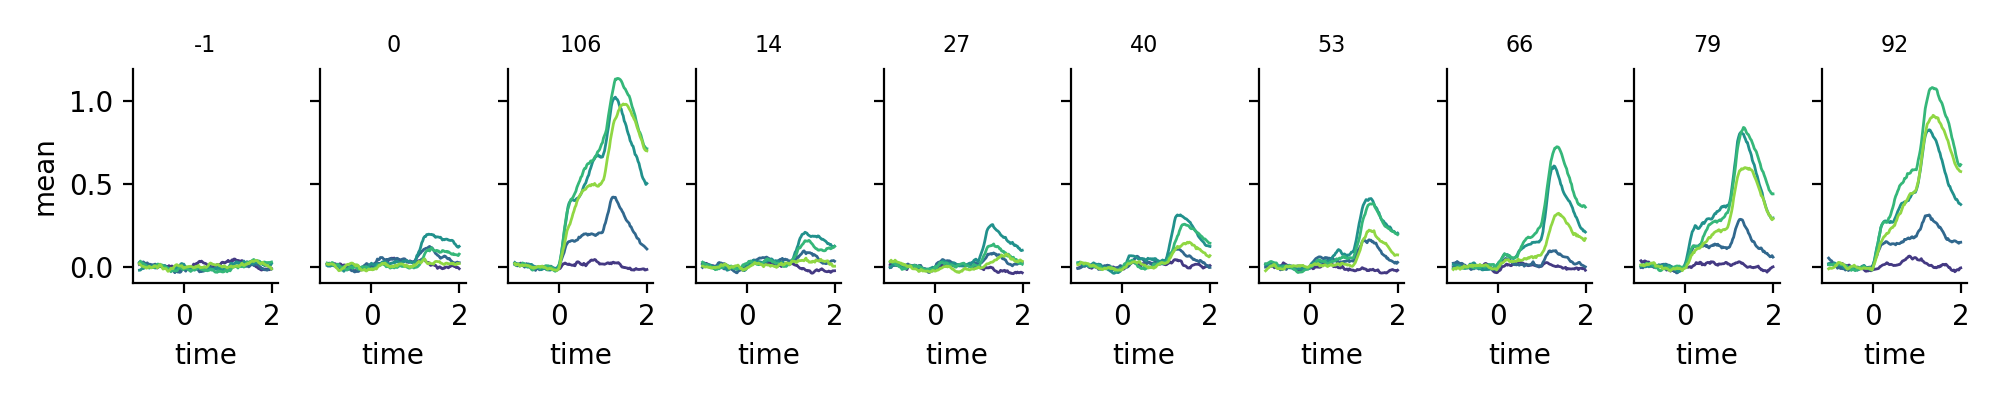

In [34]:
sizes = sorted(sdf['size'].unique())
print(sizes)
hue_var = 'morphlevel'
fg = sns.FacetGrid(data=tdf, col='morphlevel', #col_order=morphlevels, 
                   #row='size', row_order=sizes, 
                   height=2, aspect=0.5, hue='size', palette='viridis')
fg.map(pl.plot, 'time', 'mean', lw=1)
fg.set_titles('{col_name}', size=8)

In [89]:
import analyze2p.objects.selectivity as sel

In [95]:
meanr = aggr.traces_to_trials(processed2, labels, epoch='stimulus', 
                              metric='mean', n_on=None)
meanr

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py:1191: RuntimeWarning: Mean of empty slice
  mean_responses = pd.DataFrame(np.vstack([np.nanmean(traces.iloc[g.index[s_on:s_on+n_on]], axis=0)\


,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,config
1,0.386051,0.260421,0.413582,0.611742,0.441690,0.486527,0.576220,0.634173,0.356892,0.639977,...,0.568301,0.352180,0.549153,0.528655,0.453594,0.546500,0.515021,0.632318,1.154646,config002
2,0.353210,0.375714,0.798730,0.509505,0.355649,0.370039,0.372970,0.376854,0.509326,0.857561,...,0.682712,0.630080,0.844370,0.389252,0.700480,0.580848,0.591725,0.671407,0.740231,config042
3,0.329320,0.490763,0.510046,0.578383,0.389029,0.368187,0.579956,0.461009,0.401430,0.487335,...,0.521179,0.501322,0.593525,0.559843,0.749314,0.611585,0.571883,0.593232,0.645556,config037
4,0.648706,0.562293,0.665342,0.555628,0.523392,0.418596,0.779857,0.635451,0.407225,0.820097,...,0.641718,0.525308,0.759981,0.530352,0.472536,0.504566,0.683913,0.360994,0.893086,config047
5,0.391614,0.384445,0.494519,0.536700,0.414979,0.553095,0.703878,0.618257,0.552833,0.898685,...,0.921220,0.695688,0.694392,0.630548,0.668098,0.763195,0.666375,0.794978,0.562808,config014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,0.206555,0.724486,0.536051,0.395700,0.430377,0.528044,0.427234,0.534121,0.425525,0.417761,...,0.645811,0.559218,0.538734,0.465435,0.477562,0.457992,0.699014,0.541416,0.815437,config011
1497,0.424222,0.851906,0.487972,0.417550,0.321918,0.438288,0.419182,0.558454,0.480858,0.452710,...,0.512721,0.530929,0.892617,0.602012,0.537358,0.525360,0.578919,0.399547,0.748110,config036
1498,0.293100,0.343363,0.547314,0.479242,0.343943,0.391661,0.413319,0.559991,0.454954,0.543311,...,0.741386,0.559519,0.696652,0.518126,0.555349,0.616649,0.783172,0.469671,0.544506,config015
1499,0.312898,0.771529,0.552227,0.535587,0.346761,0.403672,0.461237,0.396392,0.439063,0.375632,...,0.713060,0.565982,0.585965,0.469700,0.399607,0.674631,0.841509,0.581116,1.090425,config026


In [96]:
meanr['visual_area'] = 'V1'
meanr['datakey'] = dk
id_vars = ['datakey', 'config', 'trial', 'visual_area']
response_type='response'

meanr.loc[meanr.index, 'trial'] = meanr.index.tolist()
x0 = pd.melt(meanr, id_vars=id_vars, var_name='cell',
                                value_name=response_type)

In [97]:
x0

,datakey,config,trial,visual_area,cell,response
0,20190507_JC083_fov1,config002,1.0,V1,0,0.386051
1,20190507_JC083_fov1,config042,2.0,V1,0,0.353210
2,20190507_JC083_fov1,config037,3.0,V1,0,0.329320
3,20190507_JC083_fov1,config047,4.0,V1,0,0.648706
4,20190507_JC083_fov1,config014,5.0,V1,0,0.391614
...,...,...,...,...,...,...
272995,20190507_JC083_fov1,config011,1496.0,V1,181,0.815437
272996,20190507_JC083_fov1,config036,1497.0,V1,181,0.748110
272997,20190507_JC083_fov1,config015,1498.0,V1,181,0.544506
272998,20190507_JC083_fov1,config026,1499.0,V1,181,1.090425


In [98]:
remove_offset=True
offset_type='minsub'
global_minsub=True
lcorrection = 'none'

sdf = aggr.get_stimuli(dk, experiment=experiment, match_names=True)

configs = sdf.index.tolist()
if dk in SDF.keys() and x0['response'].min() < 0:
    print("below 0: {}".format(dk))
#     if remove_offset and x0['response'].min() < 0:
#         x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')
if -1 not in sdf['morphlevel'].values and lcorrection!='none':
    print("    skippping, %s, %s (no lum)" % (va, dk))

rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf_offset = sel.correct_offset(rdf0, offset=offset_type, global_minsub=global_minsub)
#rdf = correct_luminance(rdf_offset, sdf, lcorrection='exclude')
rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
ixs_ = sel.calculate_metrics(rdf[rdf.config.isin(configs)], sdf, normalize=False)


In [110]:
ixs_['visual_area'] = 'V1'

<IPython.core.display.Javascript object>


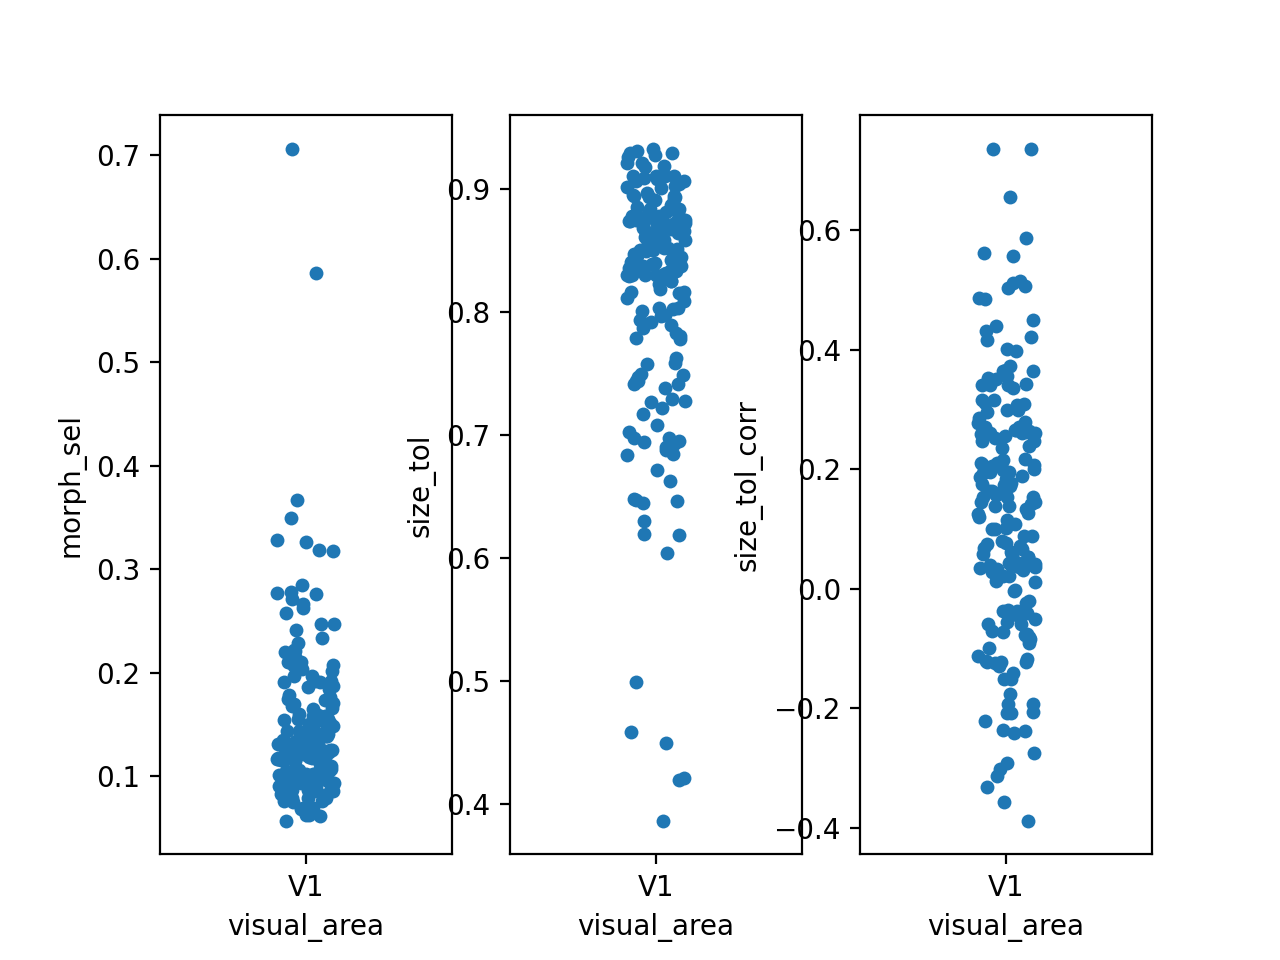

In [111]:
#plot_params=['sparseness_morphs', 'sparseness_total', 'morph_sel', 
#             'size_tol', 'size_tol_corr']#, 

plot_params = ['morph_sel', 'size_tol', 'size_tol_corr']
mean_type='mean'
fig, axn = pl.subplots(1, len(plot_params))
for i, metric in enumerate(plot_params):
    ax=axn[i]
    sns.stripplot(x='visual_area', y=metric, data=ixs_, ax=ax)